# Estimating information in Deep Representations

In this notebook, we showcase how `torch_mist` can be used for quantitative and qualitative evaluation purposes.
This example focuses on measuring how much information a deep  `resnet18` representation contains about the position of eyes, nose and mouth in the original picture.

By estimating mutual information with a simple generative estimator, we demonstrate that a pre-trained `resnet18` architecture contains substatially more information than a randomly initialized architecture.


## Loading a pre-trained architecture

In [ ]:
from torchvision.models import resnet18
from torch import nn
import torch
from torch_mist.utils.freeze import freeze


# We define a simple utility class to define the resnet18 encoder
class ResNet18Encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.resnet = resnet18(**kwargs)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return x

encoders = {
    'pretrained': freeze(ResNet18Encoder(weights='DEFAULT')),
    'random_init': freeze(ResNet18Encoder(weights=None)),
}

## Loading the CelebA dataset

In [4]:
from torchvision.datasets import CelebA
from torchvision.transforms import ToTensor


# We define a simple utility to normalize the position of the face landmarks
def normalize(coord):
    coord = coord - torch.FloatTensor([218, 178])/2.0
    coord = coord / torch.FloatTensor([218, 178])
    return coord

# utility to map normalized coordinates into the original space
def revert(coord):
    coord = coord*torch.FloatTensor([218, 178])
    coord += torch.FloatTensor([218, 178])/2.0
    return coord

landmarks = ['left_eye', 'right_eye', 'nose', 'left_mouth', 'right_mouth']

# And wrap the original CelebA dataset to return a dictionary containing the image and each landmark
class CelebALandmarks(CelebA):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, target_type='landmarks', transform=ToTensor(), **kwargs)

    def __getitem__(self, idx):
        img, landmarks = super().__getitem__(idx)
        return {
            'image': img.float(),
            'left_eye': normalize(landmarks[:2].float()),
            'right_eye': normalize(landmarks[2:4].float()),
            'nose': normalize(landmarks[4:6].float()),
            'left_mouth': normalize(landmarks[6:8].float()),
            'right_mouth': normalize(landmarks[8:].float()),
        }
            

dataset = CelebALandmarks('/data')

torch.Size([3, 218, 178])

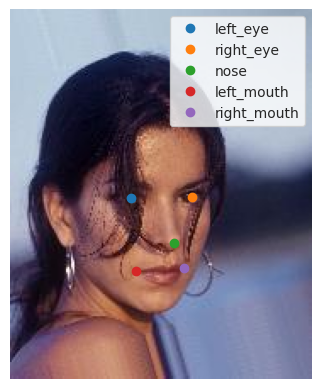

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

idx = 123

# We plot image to showcase the data
data = dataset[idx]
plt.imshow(data['image'].permute(1,2,0))

# And the corresponding landmarks
for name, value in data.items():
    if name == 'image':
        continue
    value = revert(value)
    
    plt.plot(value[0],value[1], 'o', label=name)

plt.legend()
plt.axis('off');

In [6]:
from torch.utils.data import DataLoader

# Lastly, we define a dataloader
dataloader = DataLoader(
    dataset,
    batch_size=128,
    num_workers=8
)

## Mutual Information Estimation

We use the `torch_mist` package to define 5x2 mutual information estimator (one for each landmark and for each encoder) that are jointly trained on the data using the `MultiMIEstimator` class.

In [9]:
from torch_mist.utils import train_mi_estimator
from torch_mist.estimators import doe, TransformedMIEstimator
from torch_mist.estimators.multi import MultiMIEstimator

# Dimensionality of the resnet18 representation
repr_dim = 512

# Device used for training the estimators
device = 'cuda'

estimators = {}
# We define 5x2 estimators (one for each feature and each representation) using doe (Difference of Entropies)
for landmark in landmarks:
    for representation in encoders:
        # Each estimator relies on the estimation of the difference between H(y|x) and H(y).
        # Both entropies are estimated using variational distribution transformed using spline_autoregressive flows.
        # Note that x refers to the image representations, while y to the coordinates of each landmark.
        estimators[(representation, landmark)] = doe(
            x_dim=repr_dim,
            y_dim=2,
            hidden_dims=[64, 64],
            marginal_transform_name='spline_autoregressive',
            conditional_transform_name='conditional_spline_autoregressive',
            n_conditional_transforms=2,
            n_marginal_transforms=2,
        )

# Since we are interested in estimating the mutual information between the resnet representations,

# This can be easily done by using the TransformedMIEstimator, which applies the specified transforms

mi_estimator = TransformedMIEstimator(
    # we first encode each image using the pre-trained encoder.
    transforms_rename={ ('image', representation_name): encoder for representation_name, encoder in encoders.items()},
    # before using the specified estimator.
    base_estimator=MultiMIEstimator(estimators)
)

mi_estimator

TransformedMIEstimator(
  (base_estimator): MultiMIEstimator(
    (estimators): ModuleDict(
      (image;left_eye): DoE(
        (q_Y_given_X): ConditionalTransformedNormalModule(  
        (base_dist): ConditionalStandardNormalModule()  
        (transforms): ModuleList(  
          (0-1): 2 x ConditionalSplineAutoregressive(  
            (nn): ConditionalAutoRegressiveNN(  
              (layers): ModuleList(  
                (0): MaskedLinear(in_features=514, out_features=64, bias=True)  
                (1): MaskedLinear(in_features=64, out_features=64, bias=True)  
                (2): MaskedLinear(in_features=64, out_features=62, bias=True)  
              )  
              (f): ReLU()  
            )  
          )  
        )  
      
        (q_Y): TransformedNormalModule(  
        (base_dist): Normal()  
        (transforms): ModuleList(  
          (0-1): 2 x SplineAutoregressive()  
        )  
      )
      )
      
      (image;right_eye): DoE(
        (q_Y_given_X): Co

We can then train the estimators for 20 epochs on GPU hardware

In [10]:
log =train_mi_estimator(
    estimator=mi_estimator,
    train_loader=dataloader,
    max_epochs=20,
    verbose=True,
    device='cuda',
)
log['model'] = 'trained'

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1272 [00:00<?, ?it/s]

Plot the mutual information estimation for each feature over time.

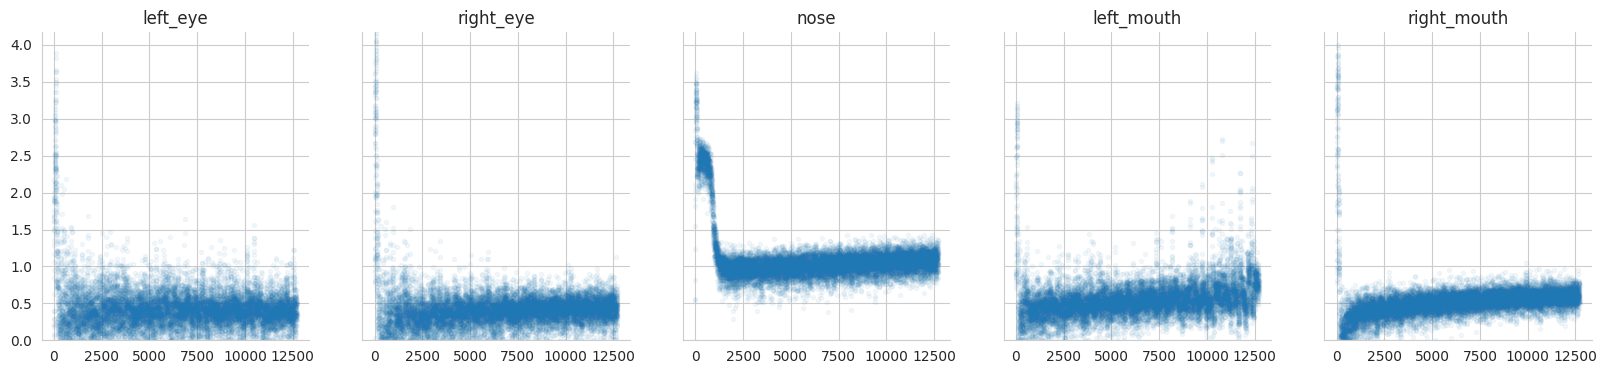

In [13]:
f, ax = plt.subplots(len,len(features), figsize=(len(features)*4, 4), sharex=True, sharey=True)
sns.despine()
for i, landmark in enumerate(features):
    ax[i].plot(log[f'I(image;{landmark})'].values, '.', alpha=0.05)
    ax[i].set_title(landmark)
    ax[i].set_ylim(0)


And compute the expected value of mutual information over the whole dataset.

Since the `DoE` estimator explicitly defines variational models $q(y)$ and $q(y|x)$, we can visualize the marginal landmark distribution and the location conditioned on the resnet representation.

(-0.5, 177.5, 217.5, -0.5)

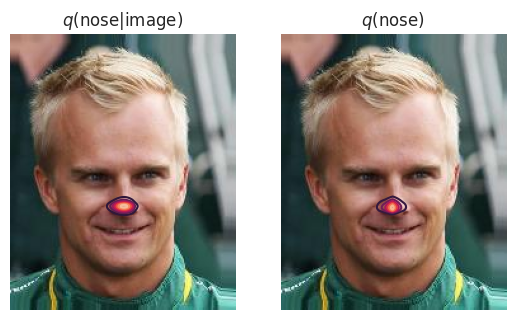

In [51]:
import numpy as np

data = dataset[12]
img = data['image']
z = pretrained_encoder(img.unsqueeze(0).to(device))
x_axis = np.arange(img.shape[1])
y_axis = np.arange(img.shape[2])

Y, X = np.meshgrid(x_axis, y_axis)
XY = normalize(torch.cat([
    torch.FloatTensor(X).unsqueeze(-1),
    torch.FloatTensor(Y).unsqueeze(-1),
],-1)).to(device)

landmark= 'nose'
estimator = estimators['pretrained'].base_estimator.estimators[f'image;{landmark}']
q_y_given_x = estimator.q_Y_given_X.condition(z.unsqueeze(0)).log_prob(XY).cpu().data.exp()
q_y = estimator.q_Y.log_prob(XY).cpu().data.exp()

f, ax = plt.subplots(1,2)

ax[0].imshow(data['image'].permute(1,2,0))
ax[0].contour(X,Y,q_y_given_x)
ax[0].set_title(f'$q$({landmark}|image)')

ax[1].imshow(data['image'].permute(1,2,0))
ax[1].contour(X,Y,q_y)
ax[1].set_title(f'$q$({landmark})')

ax[0].axis('off')
ax[1].axis('off')

We can now repeat the same procedure for the randomly initialized encoder

In [24]:
initialized_encoder = ResNet18Encoder(weights=None)

estimators = {}

for landmark in features:
    estimators[('image', landmark)] = doe(
        x_dim=repr_dim,
        y_dim=2,
        hidden_dims=[64, 64],
        marginal_transform_name='spline_autoregressive',
        conditional_transform_name='conditional_spline_autoregressive',
        n_conditional_transforms=2,
        n_marginal_transforms=2,
    )

mi_estimator_2 = TransformedMIEstimator(
    transforms={'image': initialized_encoder},
    base_estimator=MultiMIEstimator(estimators)
)

mi_estimator_2

TransformedMIEstimator(
  (base_estimator): MultiMIEstimator(
    (estimators): ModuleDict(
      (image;left_eye): DoE(
        (q_Y_given_X): ConditionalTransformedNormalModule(  
        (base_dist): ConditionalStandardNormalModule()  
        (transforms): ModuleList(  
          (0-1): 2 x ConditionalSplineAutoregressive(  
            (nn): ConditionalAutoRegressiveNN(  
              (layers): ModuleList(  
                (0): MaskedLinear(in_features=514, out_features=64, bias=True)  
                (1): MaskedLinear(in_features=64, out_features=64, bias=True)  
                (2): MaskedLinear(in_features=64, out_features=62, bias=True)  
              )  
              (f): ReLU()  
            )  
          )  
        )  
      
        (q_Y): TransformedNormalModule(  
        (base_dist): Normal()  
        (transforms): ModuleList(  
          (0-1): 2 x SplineAutoregressive()  
        )  
      )
      )
      
      (image;right_eye): DoE(
        (q_Y_given_X): Co

In [25]:
log_2 =train_mi_estimator(
    estimator=mi_estimator_2,
    train_loader=dataloader,
    max_epochs=10,
    verbose=True,
    device='cuda',
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1272 [00:00<?, ?it/s]

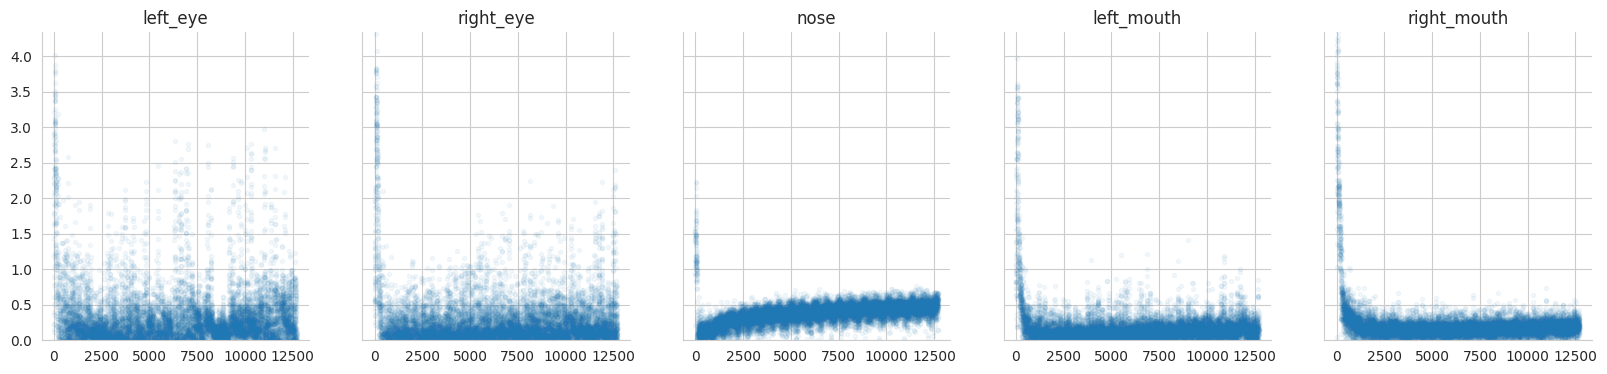

In [26]:
f, ax = plt.subplots(1,len(features), figsize=(len(features)*4, 4), sharex=True, sharey=True)
sns.despine()
for i, landmark in enumerate(features):
    ax[i].plot(log_2[f'I(image;{landmark})'].values, '.', alpha=0.05)
    ax[i].set_title(landmark)
    ax[i].set_ylim(0)


In [28]:
estimates_2=evaluate_mi(
    estimator=mi_estimator_2,
    dataloader=dataloader,
    device=device,
)

In [42]:
from torch_mist.utils import evaluate_mi

pretrained_estimates=evaluate_mi(
    estimator=mi_estimators['pretrained'],
    dataloader=dataloader,
    device=device,
)

In [43]:

estimates = [{'model': 'pre-trained', 'quantity':key, 'value': value} for key, value in pretrained_estimates.items()]
estimates += [{'model': 'random-init', 'quantity':key, 'value': value} for key, value in estimates_2.items()]

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'I(image;left_eye)'),
  Text(1, 0, 'I(image;right_eye)'),
  Text(2, 0, 'I(image;nose)'),
  Text(3, 0, 'I(image;left_mouth)'),
  Text(4, 0, 'I(image;right_mouth)')])

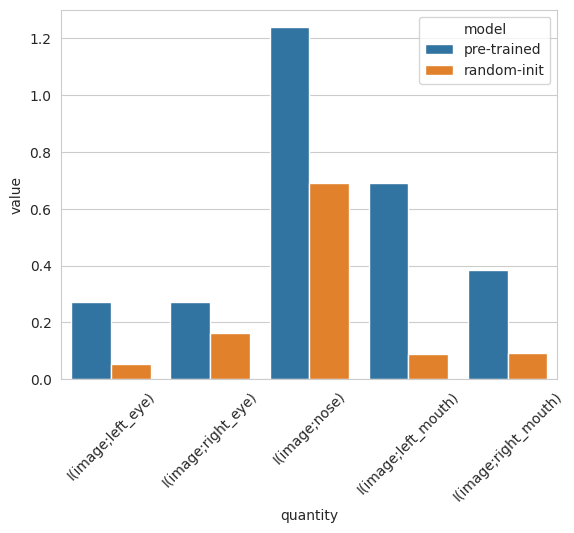

In [47]:
import pandas as pd
sns.barplot(pd.DataFrame(estimates), x='quantity', y='value', hue='model')
plt.xticks(rotation=45)

In [40]:
pd.DataFrame(estimates)

,model,quantity,value
0,pre-trained,I(image;left_eye),0.273344
1,pre-trained,I(image;right_eye),0.272665
2,pre-trained,I(image;nose),1.238309
3,pre-trained,I(image;left_mouth),0.692107
4,pre-trained,I(image;right_mouth),0.383287
5,pre-trained,model,pre-trained
6,random-init,I(image;left_eye),0.052388
7,random-init,I(image;right_eye),0.161592
8,random-init,I(image;nose),0.69148
9,random-init,I(image;left_mouth),0.087538
